In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import massapp as mass
import regutil as reg


In [2]:
data = pd.read_spss('..\\SPSS\\Data\\GISValTechSampleData.sav')
data.head()
data['ParcelId'] = data['ParcelId'].astype(int)
data['SaleDate'] = pd.to_datetime(data['SaleDate'])
data['SalesPrice'] = data['SalesPrice'].astype(int)
data['Sqft'] = data['Sqft'].astype(int)
data['LandSize'] = data['LandSize'].astype(int)
data['Quality'] = pd.Categorical(data['Quality'], ordered = True, categories = [
    'Poor', 'BelowAverage', 'Average', 'AboveAverage', 'Superior'])
data['GarageSize'] = data['GarageSize'].astype(int)
data['EffAge'] = data['EffAge'].astype(int)
data['NBHD'] = pd.Categorical(data['NBHD'].astype(int))

data.set_index('ParcelId', inplace = True)
data.head()

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD
ParcelId,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104


In [3]:
data['SPPSF'] = data['SalesPrice'] / data['Sqft']
#data.groupby(['Quality'], observed = True)['SPPSF'].describe()
data.groupby(['Quality'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ])

,count,mean,median,std
Quality,,,,
Poor,64,122.984356,119.449408,28.164216
BelowAverage,247,146.912253,145.214533,30.349647
Average,271,185.376154,184.985541,31.991147
AboveAverage,180,241.806336,238.667971,35.123588
Superior,60,307.275931,299.384849,39.976580


In [4]:
data.groupby(['NBHD'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ])

,count,mean,median,std
NBHD,,,,
101,137,116.695077,114.362734,20.943218
102,215,166.801041,161.984105,30.758226
103,258,191.348178,187.546034,33.471539
104,124,239.150479,237.894661,37.336202
105,88,289.602511,289.527589,45.697791


In [5]:
data['SYEAR'] = data['SaleDate'].dt.year
data['SMONTH'] = data['SaleDate'].dt.month
data['SDATE'] = data['SaleDate'].dt.to_period('M').dt.to_timestamp()
pd.crosstab(data['SYEAR'], data['SMONTH'])

SMONTH,1,2,3,4,5,6,7,8,9,10,11,12
SYEAR,,,,,,,,,,,,
2023,118,33,40,53,87,82,76,71,70,61,82,49


In [6]:
startdate = pd.to_datetime('1/1/2023')
basedate = pd.to_datetime('12/31/2023')
timeperiod = (basedate.to_period('M') - startdate.to_period('M')).n
timeperiod

11

In [7]:
data['Months'] = [(x - startdate.to_period('M')).n for x in data['SaleDate'].dt.to_period('M')]
data['Month'] = timeperiod - data['Months']
data.head()

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month
ParcelId,,,,,,,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11


In [10]:
modelData = pd.DataFrame({"SalesPrice" : data['SalesPrice'], "const" : 1})

# Time
modelData['MonthsSF'] = data['Months'] * data['Sqft']

# Land Size
#modelData = addContinuous(modelData, data['LandSize'], 'LN_LandSize')
#modelData['LandSize25'] = pow(data['LandSize'], .25)
modelData['LandSize50'] = pow(data['LandSize'], .50)
#modelData['LandSize75'] = pow(data['LandSize'], .75)

# Quality
modelData['SQFT_Poor'] = [r['Sqft'] if r['Quality'] == 'Poor' else 0 for i, r in data.iterrows()]
modelData['SQFT_BelowAverage'] = [r['Sqft'] if r['Quality'] == 'BelowAverage' else 0 for i, r in data.iterrows()]
modelData['SQFT_Average'] = [r['Sqft'] if r['Quality'] == 'Average' else 0 for i, r in data.iterrows()]
modelData['SQFT_AboveAverage'] = [r['Sqft'] if r['Quality'] == 'AboveAverage' else 0 for i, r in data.iterrows()]
modelData['SQFT_Superior'] = [r['Sqft'] if r['Quality'] == 'Superior' else 0 for i, r in data.iterrows()]

# Bathrooms
modelData['Bathrooms'] = data['Bathrooms']

# EffAge
def effAgeAdj(effAge):
    if effAge < 0:
        return 0
    elif effAge > 60:
        return 60
    return effAge

modelData['EffageSF75'] = [effAgeAdj(r['EffAge']) * pow(r['Sqft'], .75) for i, r in data.iterrows()]

# GarageSize
modelData['GarageSize'] = data['GarageSize']

# NBHD
modelData = reg.add_binaries(modelData, data['NBHD'], 'NBHD_105', 'NBHD', min_sales = 6)

modelData.sample(10)

,SalesPrice,const,MonthsSF,LandSize50,SQFT_Poor,SQFT_BelowAverage,SQFT_Average,SQFT_AboveAverage,SQFT_Superior,Bathrooms,EffageSF75,GarageSize,NBHD_101,NBHD_102,NBHD_103,NBHD_104
ParcelId,,,,,,,,,,,,,,,,
129758,888474,1,32790,168.454742,0,0,0,3279,0,3.5,17766.010695,704,0.0,0.0,0.0,1.0
122474,699788,1,9351,196.756194,0,0,0,3117,0,2.5,15852.077917,360,0.0,0.0,0.0,1.0
128342,565171,1,14955,175.331115,0,0,2991,0,0,3.5,9302.295809,484,0.0,0.0,0.0,1.0
137252,207578,1,1111,107.489534,0,1111,0,0,0,3.0,4233.584427,384,0.0,1.0,0.0,0.0
129723,137954,1,4752,124.531121,0,0,1188,0,0,2.0,12141.255008,0,1.0,0.0,0.0,0.0
107166,369191,1,12402,123.138134,0,0,2067,0,0,3.5,7050.715540,384,0.0,0.0,1.0,0.0
116846,438355,1,19080,110.385687,0,0,1908,0,0,3.5,9238.123336,384,0.0,0.0,1.0,0.0
112202,141196,1,9642,112.374374,0,1607,0,0,0,2.0,14467.275881,0,1.0,0.0,0.0,0.0
128077,175116,1,6715,135.029626,0,1343,0,0,0,2.0,13310.925719,0,1.0,0.0,0.0,0.0


In [11]:
col = ['SalesPrice', 'const', 'NBHD_104', 'SQFT_Average', 'Bathrooms', 'EffageSF75', 'SQFT_Poor', 'MonthsSF', 'NBHD_102', 'SQFT_Superior', 'GarageSize', 'SQFT_BelowAverage', 'NBHD_103', 'LandSize50', 'SQFT_AboveAverage', 'NBHD_101']
modelData = modelData.reindex(columns=col)
modelData.head()

,SalesPrice,const,NBHD_104,SQFT_Average,Bathrooms,EffageSF75,SQFT_Poor,MonthsSF,NBHD_102,SQFT_Superior,GarageSize,SQFT_BelowAverage,NBHD_103,LandSize50,SQFT_AboveAverage,NBHD_101
ParcelId,,,,,,,,,,,,,,,,
103525,254596,1,0.0,0,2.5,10240.717802,0,0,1.0,0,360,1573,0.0,165.302753,0,0.0
110784,1151736,1,0.0,0,5.0,10031.088058,0,0,0.0,0,484,0,0.0,118.983192,4586,0.0
116454,501824,1,0.0,2548,3.5,3586.324373,0,0,0.0,0,384,0,1.0,130.980915,0,0.0
138782,789205,1,1.0,0,2.5,6985.342882,0,0,0.0,0,360,0,0.0,185.313248,3312,0.0
102652,548042,1,1.0,0,2.5,19182.327960,0,0,0.0,0,484,0,0.0,185.504717,2455,0.0


In [13]:
# This assumes dependent variable is in the first column
while True:
    model = sm.OLS(
        modelData.iloc[:, 0],
        modelData.drop(modelData.columns[0], axis = 1)
    ).fit()
    ix = model.pvalues[model.pvalues.index != 'const'].idxmax()
    if(model.pvalues[ix] <= .10):
        break
    else:
        print("Dropping {0} p-value: {1} ".format(str(ix), model.pvalues[ix].round(3)))
        modelData.drop(columns = ix, inplace = True)

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                    OLS                  Adj. R-squared:         0.959     
Dependent Variable:       SalesPrice           AIC:                    20695.6295
Date:                     2025-03-02 13:42     BIC:                    20766.3056
No. Observations:         822                  Log-Likelihood:         -10333.   
Df Model:                 14                   F-statistic:            1383.     
Df Residuals:             807                  Prob (F-statistic):     0.00      
R-squared:                0.960                Scale:                  4.9429e+09
---------------------------------------------------------------------------------
                     Coef.      Std.Err.     t    P>|t|     [0.025       0.975]  
---------------------------------------------------------------------------------
const               51406.2379 43588.8629  1.1793 0.2386  -34154.6872 136967.1631
NBHD_104           -70529.7752 21815.5043 -3.2330 0.0013 -113351.6019 -27707.9485
SQFT_Average          181.5301     7.1235 25.4831 0.0000     167.5472    195.5129
Bathrooms           15867.9707  5213.0505  3.0439 0.0024    5635.2324  26100.7090
EffageSF75             -4.9496     0.5332 -9.2825 0.0000      -5.9963     -3.9029
SQFT_Poor             145.2292    10.5963 13.7057 0.0000     124.4297    166.0287
MonthsSF                2.1667     0.2944  7.3602 0.0000       1.5889      2.7446
NBHD_102          -112717.0542 26705.9657 -4.2207 0.0000 -165138.4063 -60295.7020
SQFT_Superior         270.2860     7.2384 37.3407 0.0000     256.0778    284.4942
GarageSize             34.7128    16.9856  2.0437 0.0413       1.3716     68.0541
SQFT_BelowAverage     157.7788     7.8671 20.0554 0.0000     142.3363    173.2212
NBHD_103          -110515.6852 21769.6531 -5.0766 0.0000 -153247.5101 -67783.8602
LandSize50            274.8478   159.1986  1.7264 0.0846     -37.6443    587.3399
SQFT_AboveAverage     221.2955     6.8556 32.2795 0.0000     207.8386    234.7524
NBHD_101          -135197.9268 30049.3413 -4.4992 0.0000 -194182.0174 -76213.8361
---------------------------------------------------------------------------------
Omnibus:                   165.414           Durbin-Watson:              2.078   
Prob(Omnibus):             0.000             Jarque-Bera (JB):           2191.433
Skew:                      -0.489            Prob(JB):                   0.000   
Kurtosis:                  10.939            Condition No.:              442453  
=================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
[2] The condition number is large, 4.42e+05. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [14]:
model.params

const                 51406.237929
NBHD_104             -70529.775235
SQFT_Average            181.530084
Bathrooms             15867.970738
EffageSF75               -4.949600
SQFT_Poor               145.229205
MonthsSF                  2.166734
NBHD_102            -112717.054167
SQFT_Superior           270.286000
GarageSize               34.712845
SQFT_BelowAverage       157.778778
NBHD_103            -110515.685153
LandSize50              274.847814
SQFT_AboveAverage       221.295473
NBHD_101            -135197.926750
dtype: float64

In [15]:
data['ESP'] = model.fittedvalues.astype(int)
data['Ratio'] = data['ESP'] / data['SalesPrice']
data.head()

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,ESP,Ratio
ParcelId,,,,,,,,,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11,233787,0.918267
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11,1145460,0.994551
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11,490545,0.977524
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11,782331,0.991290
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11,536668,0.979246


{'PRB': -0.019168108740149684, 'sig': 5.349197660161371e-05}

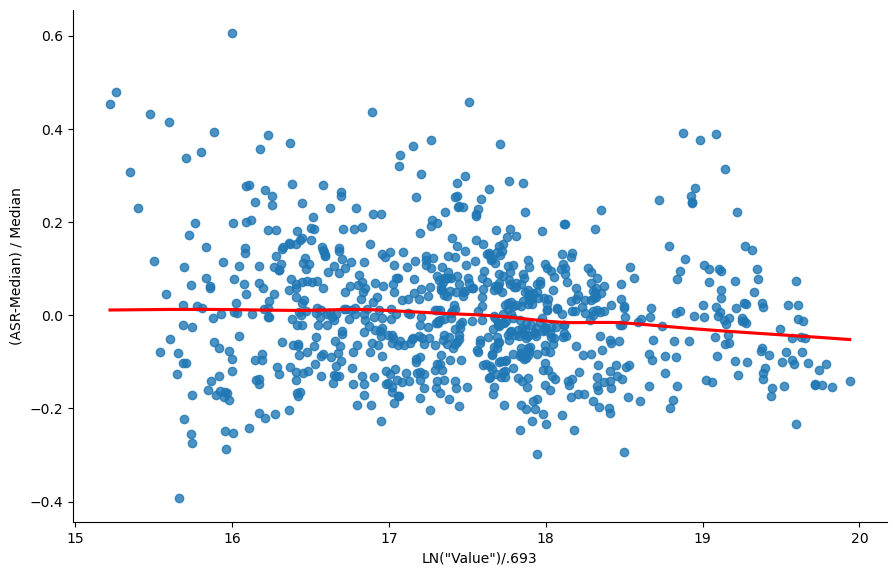

In [16]:
mass.PRB(data['ESP'], data['SalesPrice'], show_graph = True)

In [18]:
mass.ratio_statistics(data, group = 'SYEAR', predicted_value_column='ESP', sales_price_column='SalesPrice')

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
SYEAR,,,,,,,,,,
2023,822,1.013,1.005,1.000,0.610034,1.614048,1.013,10.322,-0.019,0.000


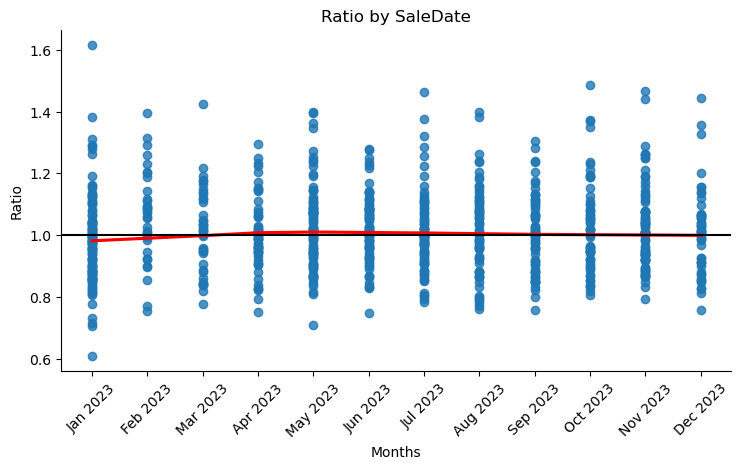

In [22]:
p = sns.lmplot(x='Months', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by SaleDate")
p.ax.ticklabel_format(useOffset=False)
label = [x.strftime('%b %Y') for x in data.sort_values(by='SaleDate')["SDATE"].unique()]
p.ax.set_xticks(range(len(label)), labels=label)
p.ax.tick_params(axis="x", labelrotation=45)
plt.axhline(y=1.00, color = 'black')

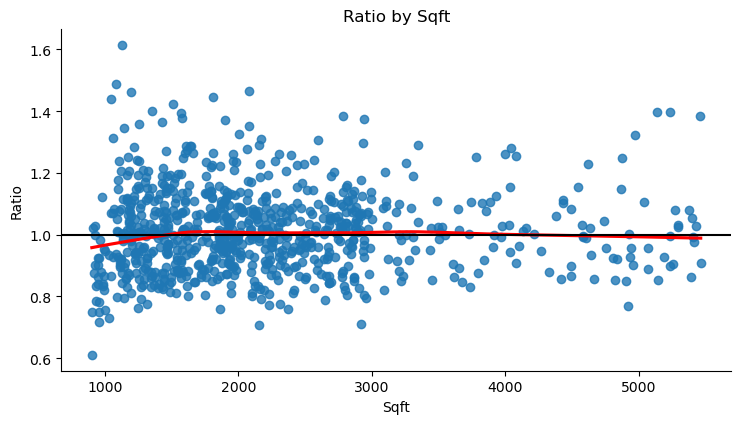

In [23]:
p = sns.lmplot(x='Sqft', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by Sqft")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

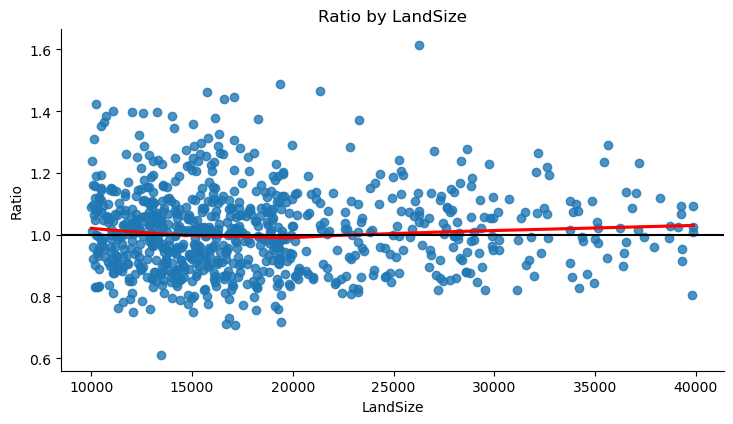

In [24]:
p = sns.lmplot(x='LandSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by LandSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

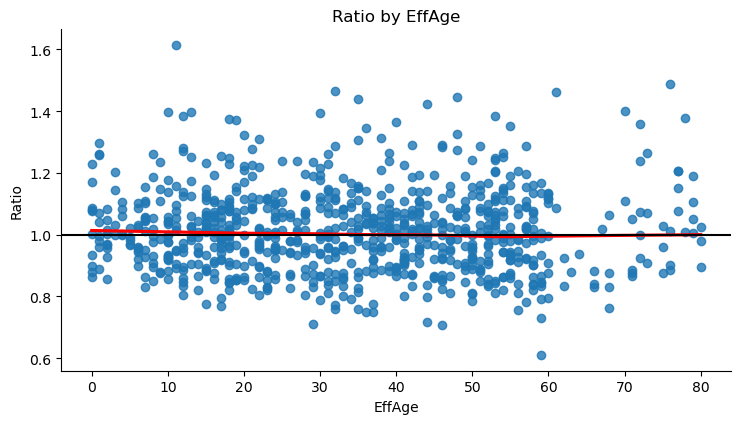

In [25]:
p = sns.lmplot(x='EffAge', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by EffAge")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

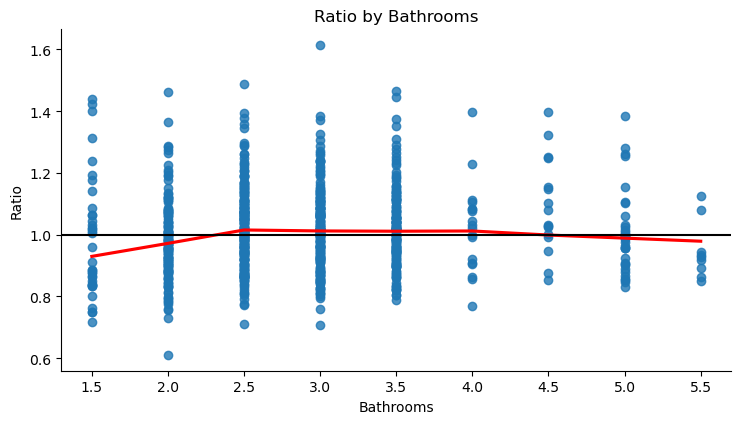

In [26]:
p = sns.lmplot(x='Bathrooms', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by Bathrooms")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

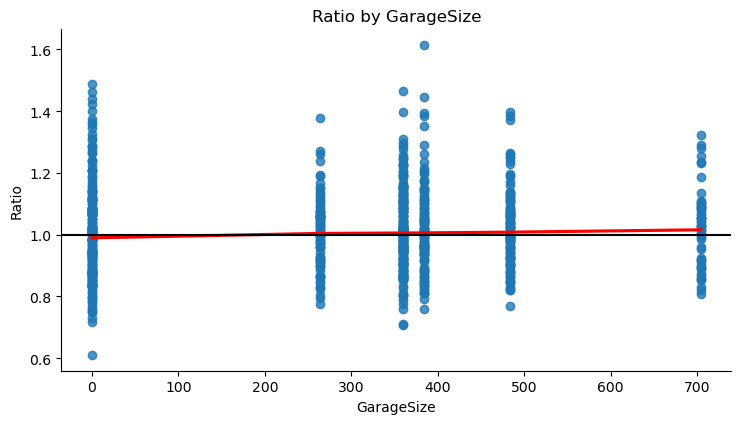

In [27]:
p = sns.lmplot(x='GarageSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by GarageSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

In [ ]:
mass.ratio_statistics(data, group='Quality', predicted_value_column="ESP", sales_price_column="SalesPrice")

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
Quality,,,,,,,,,,
Poor,64,0.992,1.001,0.991,0.610034,1.487057,1.002,12.917,-0.022,0.627
BelowAverage,247,1.017,1.009,1.002,0.717046,1.614048,1.015,10.714,-0.079,0.000
Average,271,1.011,0.995,0.997,0.706835,1.443818,1.014,10.473,-0.078,0.000
AboveAverage,180,1.019,1.014,1.002,0.770543,1.465416,1.017,8.885,-0.069,0.000
Superior,60,1.015,1.000,1.001,0.830305,1.396477,1.015,9.430,-0.077,0.015


In [29]:
mass.ratio_statistics(data, group='NBHD', predicted_value_column="ESP", sales_price_column="SalesPrice")

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
NBHD,,,,,,,,,,
101,137,1.009,1.000,1.000,0.610034,1.487057,1.009,13.805,-0.110,0.008
102,215,1.014,1.008,1.000,0.758302,1.614048,1.014,9.721,-0.173,0.000
103,258,1.013,1.008,1.000,0.706835,1.443818,1.013,9.598,-0.189,0.000
104,124,1.015,1.011,1.000,0.805513,1.465416,1.015,9.196,-0.148,0.000
105,88,1.016,0.999,1.000,0.770543,1.397443,1.016,9.954,-0.300,0.000


In [32]:
t = mass.ratio_statistics(data, 'SDATE', predicted_value_column="ESP", sales_price_column="SalesPrice")
t.index = t.index.strftime('%b %Y')
t

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
SDATE,,,,,,,,,,
Jan 2023,118,0.982,0.973,0.976,0.610034,1.614048,1.006,10.794,-0.008,0.584
Feb 2023,33,1.063,1.073,1.013,0.755073,1.393653,1.049,10.668,-0.042,0.055
Mar 2023,40,1.014,1.017,1.000,0.776499,1.423227,1.014,10.565,-0.027,0.181
Apr 2023,53,1.004,0.989,0.991,0.750260,1.295300,1.013,9.299,-0.014,0.443
May 2023,87,1.028,1.020,1.023,0.710889,1.397443,1.005,10.441,-0.011,0.456
Jun 2023,82,1.024,1.019,1.024,0.749519,1.279979,1.000,8.360,0.002,0.853
Jul 2023,76,1.009,0.996,1.002,0.784191,1.461681,1.007,9.536,-0.028,0.106
Aug 2023,71,1.013,1.006,1.006,0.761896,1.399927,1.007,11.155,-0.009,0.585
Sep 2023,70,1.003,1.001,0.980,0.758542,1.305538,1.024,9.704,-0.011,0.407


In [34]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .75), ]

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,ESP,Ratio
ParcelId,,,,,,,,,,,,,,,,,
102047,2023-01-12,127731,955,19432,1.5,BelowAverage,0,44,101,133.749738,2023,1,2023-01-01,0,11,91589,0.717046
119180,2023-01-13,130975,1127,26275,3.0,BelowAverage,384,11,102,116.215617,2023,1,2023-01-01,0,11,211400,1.614048
133036,2023-01-18,103727,907,13450,2.0,Poor,0,59,101,114.362734,2023,1,2023-01-01,0,11,63277,0.610034
136487,2023-01-23,109611,1030,16811,2.0,Poor,0,59,101,106.418447,2023,1,2023-01-01,0,11,80071,0.730502
101794,2023-01-27,504089,2156,17134,3.0,Average,360,46,103,233.807514,2023,1,2023-01-01,0,11,356308,0.706835
108121,2023-05-14,740719,2918,16688,2.5,Average,360,29,103,253.844757,2023,5,2023-05-01,4,7,526569,0.710889
120850,2023-06-26,109114,903,12074,1.5,Poor,0,36,101,120.834994,2023,6,2023-06-01,5,6,81783,0.749519


In [35]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .75), ].to_excel('.\\reports\\additivebadratio.xlsx')